In [1]:
#from __future__ import print_function
#import sys
#import time
#import libtiepie
#from printinfo import *

In [3]:
from __future__ import absolute_import, division, print_function
from builtins import *  # @UnusedWildImport

from mcculw import ul
from mcculw.device_info import DaqDeviceInfo
from mcculw.enums import *

try:
    from mcculw.console_examples_util import config_first_detected_device
except ImportError:
    from mcculw.console_examples_util import config_first_detected_device
import numpy as np
from time import perf_counter_ns 
import matplotlib.pyplot as plt
#from matplotlib import rc

In [3]:
use_device_detection = True
dev_id_list = []
board_num = 0
channel_in= 0
channel_out = 0

In [4]:
config_first_detected_device(board_num, dev_id_list)
daq_dev_info = DaqDeviceInfo(board_num)

Found 1 DAQ device(s):
  USB-1208FS (1667411) - Device ID = 130


In [5]:
ai_info = daq_dev_info.get_ai_info()
ao_info = daq_dev_info.get_ao_info()
ao_range = ao_info.supported_ranges[0]

In [6]:
ai_info.supported_ranges

[<ULRange.BIP20VOLTS: 15>,
 <ULRange.BIP10VOLTS: 1>,
 <ULRange.BIP5VOLTS: 0>,
 <ULRange.BIP4VOLTS: 16>,
 <ULRange.BIP2PT5VOLTS: 2>,
 <ULRange.BIP2VOLTS: 14>,
 <ULRange.BIP1PT25VOLTS: 3>,
 <ULRange.BIP1VOLTS: 4>]

In [7]:
print(ao_info.supported_ranges)
print('Max Range: ' +str(ao_range.range_max) + ' V')
print('Min Range: ' +str(ao_range.range_min) + ' V')

[<ULRange.UNI4VOLTS: 114>]
Max Range: 4.0 V
Min Range: 0 V


In [8]:
steps = 4   
output_voltage = np.arange(0, ao_range.range_max + (ao_range.range_max/steps), ao_range.range_max/steps)
print('Output Voltages: ' +str(output_voltage))

Output Voltages: [0. 1. 2. 3. 4.]


In [9]:
ul.v_out(board_num, channel_out, ao_range, output_voltage[2])

In [10]:
value = ul.v_in(board_num, 0, ULRange.BIP20VOLTS)
value

0.56640625

In [11]:
n=0
ul.v_out(board_num, channel_out, ao_range, output_voltage[n])
time_p_voltage = 0.5; time_p_voltage_updated = time_p_voltage; 
total_time_measurement = time_p_voltage * len(output_voltage) 
time = 0; time_recording = [time]; voltage_recording = [n]
time_zero = perf_counter_ns()
while time < total_time_measurement:
    if time > time_p_voltage_updated:
        #print('before: ' + str(time_p_voltage))
        #print('n before: ' + str(n))

        n = n+1
        ul.v_out(board_num, channel_out, ao_range, output_voltage[n])
        time_p_voltage_updated = time_p_voltage * (n+1)
        #print('after: ' + str(time_p_voltage_updated))
        #print('n after: ' + str(n))

        #print('')
    
    value = ul.v_in(board_num, 0, ULRange.BIP20VOLTS)
    time = (perf_counter_ns()-time_zero) * (10**(-9))
    voltage_recording = np.append(voltage_recording,value)
    time_recording = np.append(time_recording,time)  

Text(0.5, 1.0, 'Blue Box Voltage Steps: Voltage Increase of 1 V per Step   |   Pins input 1 & 13 output')

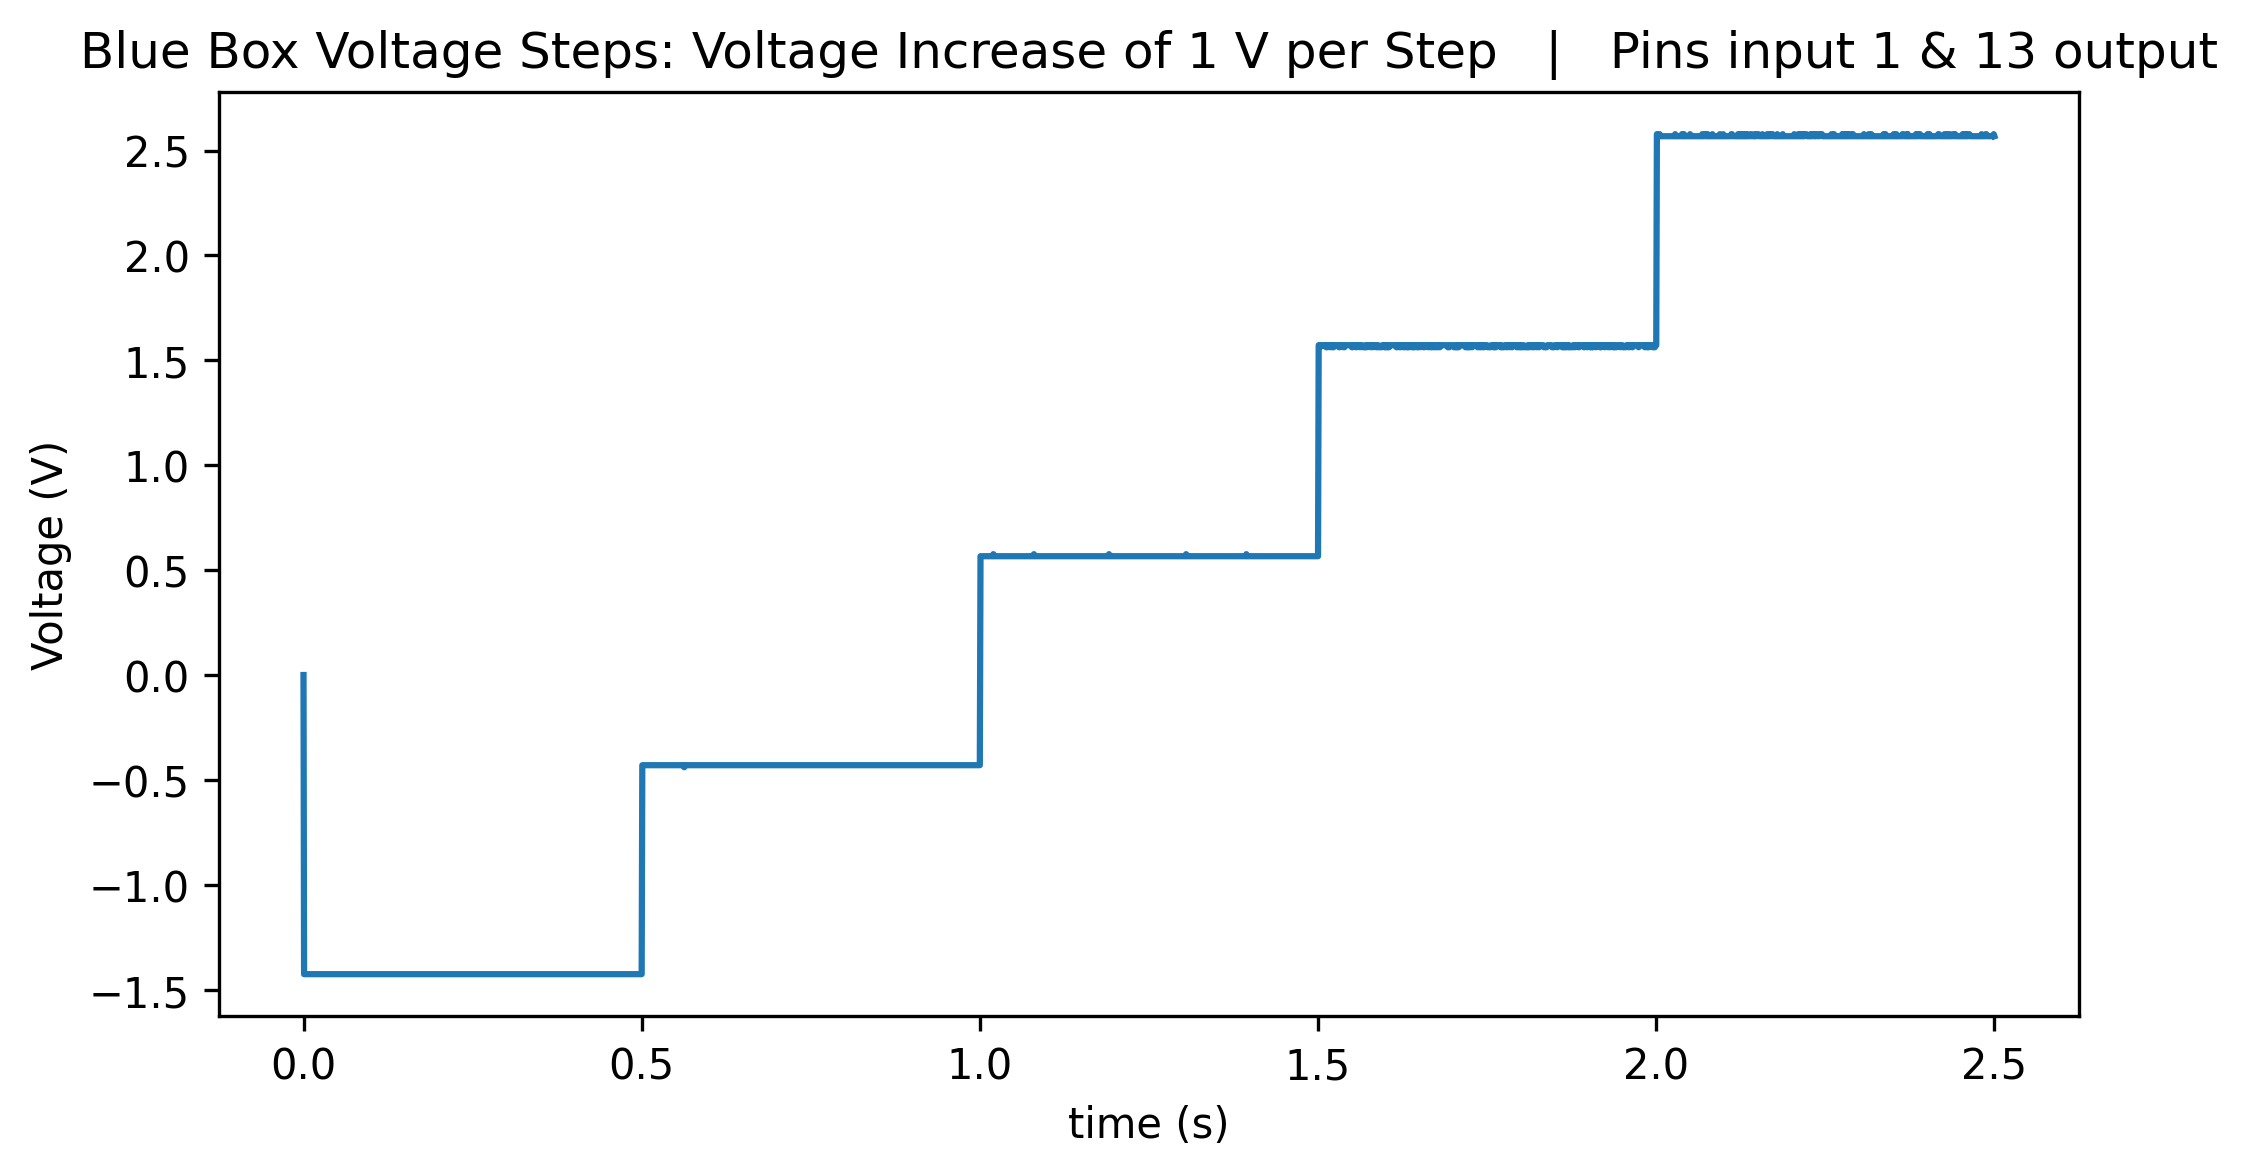

In [12]:
plt.figure(figsize=(8, 4), dpi=300)
plt.plot(time_recording, voltage_recording)
plt.xlabel('time (s)')
plt.ylabel('Voltage (V)')
plt.title("Blue Box Voltage Steps: Voltage Increase of 1 V per Step   |   Pins input 1 & 13 output")


In [13]:
ul.release_daq_device(board_num)

In [1]:
from __future__ import print_function
import sys
import time
import libtiepie
from printinfo import *